<a href="https://colab.research.google.com/github/MorozovDesu/neural_network_technologies/blob/main/2_%D0%9B%D0%B0%D0%B1%D0%B0_%D0%9D%D0%B5%D0%B9%D1%80%D0%BE%D1%81%D0%B5%D1%82%D0%B5%D0%B2%D1%8B%D0%B5_%D1%82%D0%B5%D1%85%D0%BD%D0%BE%D0%BB%D0%BE%D0%B3%D0%B8%D0%B8_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [43]:
import sys
import seaborn as sns
import numpy as np
np.set_printoptions(threshold=sys.maxsize)
import pandas as pd
import os
import h5py
import PIL
import cv2
import tensorflow as tf
import tensorflow.keras as keras

from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pylab as plt
from matplotlib import cm
%matplotlib inline
import matplotlib.pylab as pylab
pylab.rcParams["figure.figsize"] = (14,8)

#Создание многослойной сети для работы с датасетом

In [44]:
class Network(object): # используется для описания нейронной сети
    def __init__(self, sizes): # конструктор класса
# self – указатель на объект класса
# sizes – список размеров слоев нейронной сети
        self.num_layers = len(sizes) # задаем количество слоев нейронной сети
        self.sizes = sizes # задаем список размеров слоев нейронной сети
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]] # задаем случайные начальные смещения
        self.weights = [np.random.randn(y, x) for x, y in zip(sizes[:-1], sizes[1:])] # задаем случайные начальные веса связей

    def sigmoid(self,z): # определение сигмоидальной функции активации
        return 1.0/(1.0+np.exp(-z))

    def feedforward(self, a):
        for b, w in zip(self.biases, self.weights):
            a = self.sigmoid(np.dot(w, a)+b)
        return a

    def SGD( # Стохастический градиентный спуск
        self # указатель на объект класса
        , training_data # обучающая выборка
        , epochs # количество эпох обучения
        , mini_batch_size # размер подвыборки
        , eta # скорость обучения
        , test_data # тестирующая выборка
        ):
        test_data = list(test_data) # создаем список объектов тестирующей выборки
        n_test = len(test_data) # вычисляем длину тестирующей выборки
        training_data = list(training_data) # создаем список объектов обучающей выборки
        n = len(training_data) # вычисляем размер обучающей выборки
        for j in range(epochs): # цикл по эпохам
            random.shuffle(training_data) # перемешиваем элементы обучающей выборки
            mini_batches = [training_data[k:k+mini_batch_size] for k in range(0, n, mini_batch_size)] # создаем подвыборки
            for mini_batch in mini_batches: # цикл по подвыборкам
              #print(len(mini_batch[0][0]))
              self.update_mini_batch(mini_batch, eta) # один шаг градиентного спуска
            print ("Epoch {0}: {1} / {2}".format(j, self.evaluate(test_data), n_test)) # смотрим прогресс в обучении

    def update_mini_batch( # Шаг градиентного спуска
        self # указатель на объект класса
        , mini_batch # подвыборка
        , eta # скорость обучения
        ):
        nabla_b = [np.zeros(b.shape) for b in self.biases] # список градиентов dC/db для каждого слоя (первоначально заполняются нулями)
        nabla_w = [np.zeros(w.shape) for w in self.weights] # список градиентов dC/dw для каждого слоя (первоначально заполняются нулями)
        for x, y in mini_batch:
            delta_nabla_b, delta_nabla_w = self.backprop(x, y) # послойно вычисляем градиенты dC/db и dC/dw для текущего прецедента (x, y)
            nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)] # суммируем градиенты dC/db для различных прецедентов текущей подвыборки
            nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)] # суммируем градиенты dC/dw для различных прецедентов текущей подвыборки
        self.weights = [w-(eta/len(mini_batch))*nw for w, nw in zip(self.weights, nabla_w)] # обновляем все веса w нейронной сети
        self.biases = [b-(eta/len(mini_batch))*nb for b, nb in zip(self.biases, nabla_b)] # обновляем все смещения b нейронной сети

    def backprop( # Алгоритм обратного распространения
        self # указатель на объект класса
      ,x # вектор входных сигналов ,
      ,y # ожидаемый вектор выходных сигналов
      ):
        nabla_b = [np.zeros(b.shape) for b in self.biases] # список градиентов dC/db для каждого слоя (первоначально заполняются нулями)
        nabla_w = [np.zeros(w.shape) for w in self.weights] # список градиентов dC/dw для каждого слоя (первоначально заполняются нулями)
        # определение переменных
        activation = x # выходные сигналы слоя (первоначально соответствует выходным сигналам 1-го слоя или входным сигналам сети)
        activations = [x] # список выходных сигналов по всем слоям (первоначально содержит только выходные сигналы 1-го слоя)
        zs = [] # список активационных потенциалов по всем слоям (первоначально пуст)
        # прямое распространение
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation)+b # считаем активационные потенциалы текущего слоя
            zs.append(z) # добавляем элемент (активационные потенциалы слоя) в конец списка
            activation = self.sigmoid(z) # считаем выходные сигналы текущего слоя, применяя сигмоидальную функцию активации к активационным потенциалам слоя
            activations.append(activation) # добавляем элемент (выходные сигналы слоя) в конец списка
  # обратное распространение
        delta = self.cost_derivative(activations[-1], y) * self.sigmoid_prime(zs[-1]) # считаем меру влияния нейронов выходного слоя L на величину ошибки (BP1)
        nabla_b[-1] = delta # градиент dC/db для слоя L (BP3)
        nabla_w[-1] = np.dot(delta, activations[-2].transpose()) # градиент dC/dw для слоя L (BP4)
        for l in range(2, self.num_layers):
          z = zs[-l] # активационные потенциалы l-го слоя (двигаемся по списку справа налево)
          sp = self.sigmoid_prime(z) # считаем сигмоидальную функцию от активационных потенциалов l-го слоя
          delta = np.dot(self.weights[-l+1].transpose(), delta) * sp # считаем меру влияния нейронов l-го слоя на величину ошибки (BP2)
          nabla_b[-l] = delta # градиент dC/db для l-го слоя (BP3)
          nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())# градиент dC/dw для l-го слоя (BP4)
        return (nabla_b, nabla_w)

    def evaluate(self, test_data): # Оценка прогресса в обучении
        test_results = [(np.argmax(self.feedforward(x)), y) for (x, y) in test_data]
        return sum(int(x == y) for (x, y) in test_results)

    def cost_derivative(self, output_activations, y): # Вычисление частных производных стоимостной функции по выходным сигналам последнего слоя
      return (output_activations-y)

    def sigmoid_prime(self,z):# Производная сигмоидальной функции
      return self.sigmoid(z)*(1-self.sigmoid(z))


In [45]:
input_folder = 'drive/MyDrive/archive/all_letters_image/all_letters_image/'
all_letters_filename = os.listdir(input_folder)
len(all_letters_filename)

14190

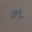

In [46]:
#Это одно из наших изображений. Размер каждого изображения составляет 32 на 32 пикселя.
#Затем мы преобразуем каждое изображение в 3d-массив numpy.
i = Image.open("drive/MyDrive/archive/all_letters_image/all_letters_image/20_102.png")
i

In [47]:
i_arr = np.array(i)
# i_arr
# Все 32 матрицы внутри этого массива представляют собой одно изображение.
# Каждая матрица представляет собой 1 строку этого изображения.
# Длина одной строки изображения составляет 32 пикселя, поэтому каждая матрица имеет 32 строки.
# Каждая строка матрицы имеет 4 столбца и представляет собой 1 пиксель. Для этого пикселя каждый столбец представляет собой значения цвета - насколько он красный, зеленый и синий - плюс непрозрачность цветов (последний столбец).
# Поэтому каждая матрица имеет размер 32 на 4. Общее количество пикселей в одном изображении составляет 32 * 32 = 1024.

# Каждое значение цвета находится в диапазоне [0:255].
# Это означает, что для каждого цвета существует 256 оттенков. В сумме все комбинации этих цветов дают нам 256ˆ3 = 16 777 216 возможных цветов.



In [48]:
from keras.preprocessing import image
import numpy as np

# Функция для преобразования изображения в тензор
# Параметры:
# - img_name: Имя файла изображения
# - input_folder: Путь к папке, где находится изображение
# Возвращает:
# - Тензорное представление изображения
def img_to_array(img_name, input_folder):
    # Загрузка изображения из указанной папки и изменение его размера до 32x32 пикселей
    img = image.load_img(input_folder + img_name, target_size=(32, 32))

    # Преобразование изображения в массив NumPy
    x = image.img_to_array(img)

    # Расширение размерности массива для подготовки его к обработке нейронной сетью
    return np.expand_dims(x, axis=0)

# Функция для преобразования списка имен изображений в тензор
# Параметры:
# - img_names: Список имен файлов изображений
# - input_folder: Путь к папке, где находятся изображения
# Возвращает:
# - Массив NumPy, содержащий тензоры всех изображений из списка
def data_to_tensor(img_names, input_folder):
    # Создание списка тензоров путем применения функции img_to_array к каждому имени изображения
    list_of_tensors = [img_to_array(img_name, input_folder) for img_name in img_names]

    # Стекирование отдельных тензоров вертикально для создания одного массива NumPy
    return np.vstack(list_of_tensors)


In [49]:
# Загрузка данных из CSV-файла в переменную "data"
data = pd.read_csv("drive/MyDrive/archive/all_letters_info.csv")
# Извлечение имен файлов изображений из столбца "file"
image_names = data['file']
letters = data[ 'letter']
backgrounds = data['background'].values
targets = data['label'].values
tensors = data_to_tensor(image_names, input_folder)
# tensors[0]


In [50]:
# Вывод размера (формы) массива тензоров
print('Форма тензоров:', tensors.shape)
# Вывод размера (формы) массива меток (целевых значений)
print('Форма меток (целевых значений):', targets.shape)

Форма тензоров: (14190, 32, 32, 3)
Форма меток (целевых значений): (14190,)


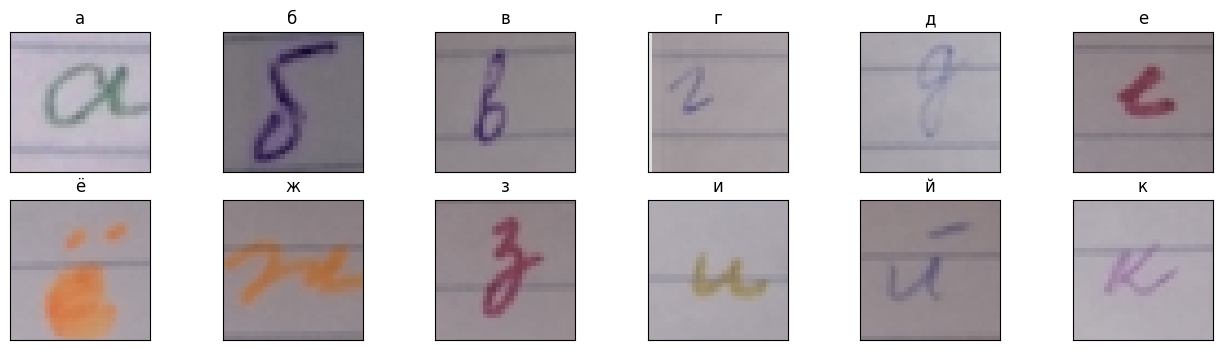

In [51]:
# Функция для отображения изображений из файлов с использованием OpenCV
# Параметры:
# - img_path: Путь к файлу изображения
# - ax: Объект для отображения изображения (область на графике)
def display_images(img_path, ax):
    # Загрузка изображения из указанного пути
    img = cv2.imread(input_folder + img_path)

    # Отображение изображения, преобразовав его из формата BGR в RGB
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

# Создание графического окна с определенными размерами
fig = plt.figure(figsize=(16, 4))

# Цикл для отображения 12 изображений
for i in range(12):
    # Создание области для каждого изображения внутри графического окна
    ax = fig.add_subplot(2, 6, i + 1, xticks=[], yticks=[], title=letters[i * 50])

    # Вызов функции для отображения изображения с указанным именем файла и заданной областью (ax)
    display_images(image_names[i * 50], ax)

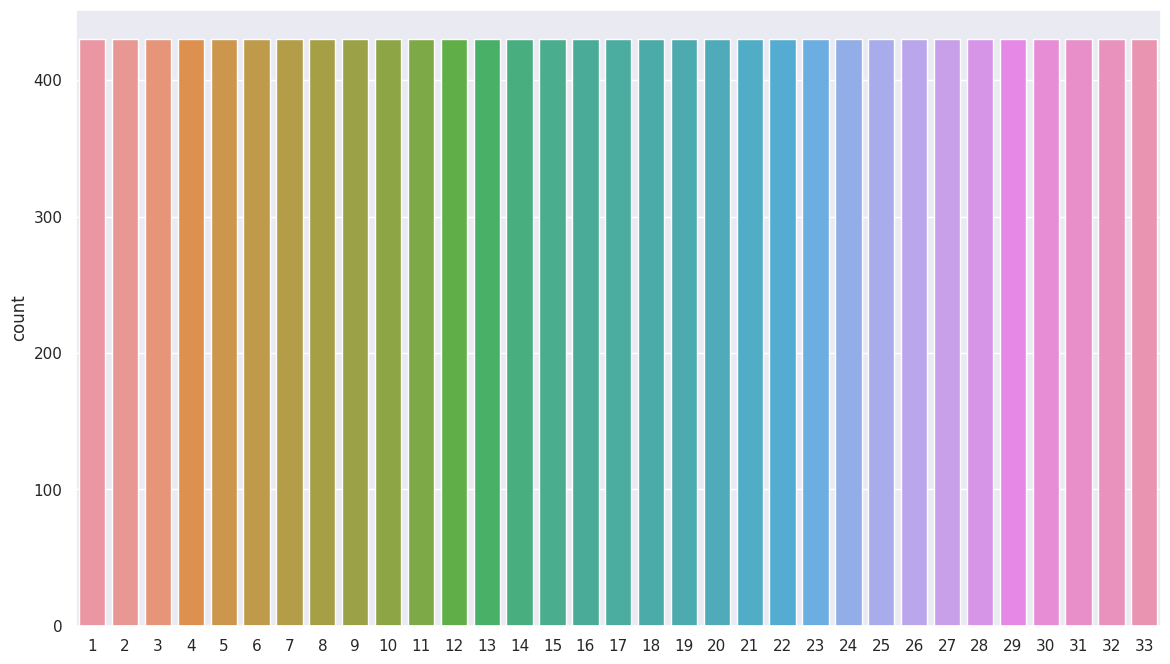

In [77]:
# Создание графика countplot
sns.set(style="darkgrid")
ax = sns.countplot(x=targets)

# Отображение графика
plt.show()

In [53]:
# Классы идеально сбалансированы, что очень важно для классификационной модели.
# Если классы несбалансированы, то модель будет пытаться максимизировать точность
# для большинства классов, оставляя без внимания другие классы, что приведет к менее точным прогнозам для меньшинств.

In [54]:
# Нормализация
# Для уменьшения влияния перепадов освещенности мы проводим нормализацию.
X = tensors.astype("float32")/255
# Кроме того, CNN быстрее сходится на данных [0...1], чем на [0...255]. Преобразуем входные данные к типу float, а затем разделим на 255 (максимальная яркость для каждого цвета).

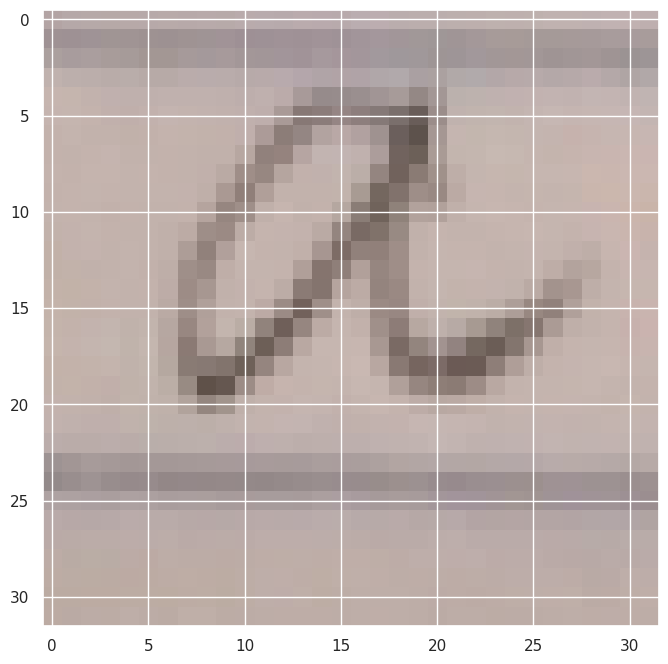

In [79]:
arr = X[2]
arr_ = np.squeeze(arr)
plt.imshow(arr_)
plt.show()

In [56]:
targets[0]

1

In [57]:
y = targets

img_rows, img_cols = 32, 32 # потому что наши картинки имеют размер 32 на 32 пикселя
num_classes = 33 # потому что в русинском алфавите 33 буквы

y = keras.utils.to_categorical(y-1, num_classes) # targets-1, потому что наш список начинается с 1, а не с 0, как ожидает keras

In [58]:
print(X.shape)
print(y.shape)

(14190, 32, 32, 3)
(14190, 33)


In [59]:
def captch_ex(file_name):
    img = cv2.imread(file_name)
    img_final = cv2.imread(file_name)
    img2gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, mask = cv2.threshold(img2gray, 180, 255, cv2.THRESH_BINARY)
    image_final = cv2.bitwise_and(img2gray, img2gray, mask=mask)
    ret, new_img = cv2.threshold(image_final, 180, 255, cv2.THRESH_BINARY)  # for black text , cv.THRESH_BINARY_INV

    '''
            line  8 to 12  : Remove noisy portion
    '''
    kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (3,
                                                         3))  # to manipulate the orientation of dilution , large x means horizonatally dilating  more, large y means vertically dilating more
    dilated = cv2.dilate(new_img, kernel, iterations=9)  # dilate , more the iteration more the dilation

    # for cv2.x.x

    contours, hierarchy = cv2.findContours(new_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)  # findContours returns 3 variables for getting contours

    for contour in contours:
        # get rectangle bounding contour
        [x, y, w, h] = cv2.boundingRect(contour)

        # Don't plot small false positives that aren't text
        if w < 35 and h < 35:
            continue

        # draw rectangle around contour on original image
        cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 255), 2)

        '''
        #you can crop image and send to OCR  , false detected will return no text :)
        cropped = img_final[y :y +  h , x : x + w]

        s = file_name + '/crop_' + str(index) + '.png'
        cv2.imwrite(s , cropped)
        index = index + 1

        '''
    # write original image with added contours to disk
    cv2.imshow('captcha_result', img)
    cv2.waitKey()

In [60]:
file_name = 'drive/MyDrive/archive/all_letters_image/all_letters_image/04_100.png'
# captch_ex(file_name)

In [61]:
# Grayscaled tensors
X_grey = np.dot(X[...,:3], [0.299, 0.587, 0.114])
# X_grey = tf.expand_dims(X_grey, axis=3)
print ('Grayscaled Tensor shape:', X_grey.shape)

Grayscaled Tensor shape: (14190, 32, 32)


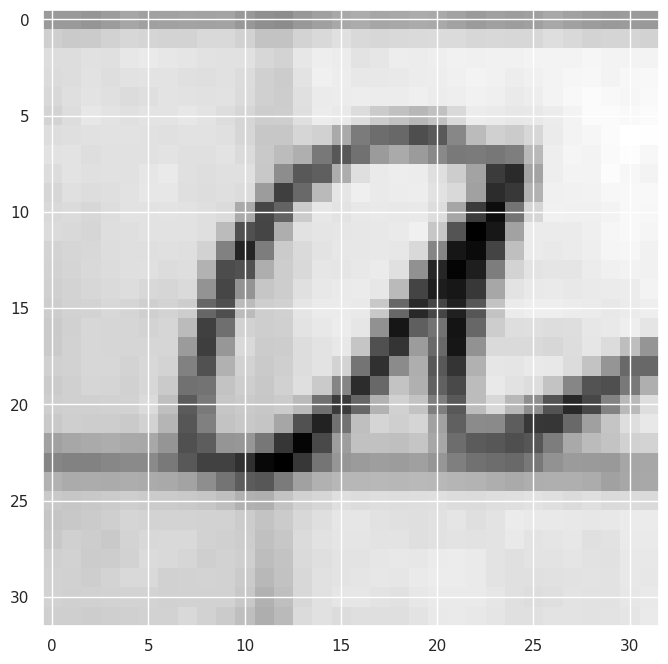

In [80]:
plt.imshow(X_grey[3], cmap=plt.get_cmap("gray"))

In [63]:
# Split the data into train, validation and test sets.

X_train_whole, X_test, y_train_whole, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train_whole, y_train_whole, test_size=0.1, random_state=1)

In [64]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample/image mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

# grey_X_train = tf.expand_dims(X_train, axis=3)
# grey_X_val = tf.expand_dims(X_val, axis=3)
# grey_X_test = tf.expand_dims(X_test, axis=3)

datagen.fit(X_train)

In [65]:
# Define the model architecture

deep_RU_model = Sequential()

deep_RU_model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu', input_shape = (img_rows,img_cols,3)))
deep_RU_model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
deep_RU_model.add(MaxPooling2D(pool_size=(2,2)))
deep_RU_model.add(Dropout(0.25))


deep_RU_model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',
                 activation ='relu'))
deep_RU_model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',
                 activation ='relu'))
deep_RU_model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
deep_RU_model.add(Dropout(0.25))


deep_RU_model.add(Flatten())
deep_RU_model.add(Dense(256, activation = "relu"))
deep_RU_model.add(Dropout(0.5))
deep_RU_model.add(Dense(33, activation = "softmax"))

In [66]:
# Define the optimizer
optimizer = RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-08)

In [67]:
# Compile the model:
deep_RU_model.compile(loss="categorical_crossentropy", optimizer = optimizer,metrics=["accuracy"])

In [68]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

In [69]:
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=50)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [70]:
history = deep_RU_model.fit(datagen.flow(X_train,y_train, batch_size=90), validation_data = (X_val, y_val),
                            epochs=5, callbacks=[learning_rate_reduction, es, mc])# сделать epochs=139

Epoch 1/5
128/128 [==============================] - ETA: 0s - loss: 3.4949 - accuracy: 0.0331


Epoch 1: val_accuracy improved from -inf to 0.04225, saving model to best_model.h5
128/128 [==============================] - 114s 883ms/step - loss: 3.4949 - accuracy: 0.0331 - val_loss: 3.4814 - val_accuracy: 0.0423 - lr: 0.0010


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/5
128/128 [==============================] - ETA: 0s - loss: 3.4607 - accuracy: 0.0485


Epoch 2: val_accuracy improved from 0.04225 to 0.04617, saving model to best_model.h5
128/128 [==============================] - 115s 898ms/step - loss: 3.4607 - accuracy: 0.0485 - val_loss: 3.4276 - val_accuracy: 0.0462 - lr: 0.0010
Epoch 3/5
128/128 [==============================] - ETA: 0s - loss: 3.4156 - accuracy: 0.0523


Epoch 3: val_accuracy improved from 0.04617 to 0.05790, saving model to best_model.h5
128/128 [==============================] - 112s 872ms/step - loss: 3.4156 - accuracy: 0.0523 - val_loss: 3.3859 - val_accuracy: 0.0579 - lr: 0.0010
Epoch 4/5
128/128 [==============================] - ETA: 0s - loss: 3.3886 - accuracy: 0.0559


Epoch 4: val_accuracy improved from 0.05790 to 0.06025, saving model to best_model.h5
128/128 [==============================] - 112s 874ms/step - loss: 3.3886 - accuracy: 0.0559 - val_loss: 3.3879 - val_accuracy: 0.0603 - lr: 0.0010
Epoch 5/5
128/128 [==============================] - ETA: 0s - loss: 3.3591 - accuracy: 0.0628


Epoch 5: val_accuracy improved from 0.06025 to 0.08529, saving model to best_model.h5
128/128 [==============================] - 113s 879ms/step - loss: 3.3591 - accuracy: 0.0628 - val_loss: 3.3127 - val_accuracy: 0.0853 - lr: 0.0010


In [71]:
# load the saved model
# saved_model = load_model('/kaggle/input/deep-ru-letters-cnn-tutorial/best_model.h5')
saved_model = load_model('best_model.h5')

# evaluate the model
_, train_acc = saved_model.evaluate(X_train, y_train, verbose=0)
_, valid_acc = saved_model.evaluate(X_val, y_val, verbose=0)

print('Train: %.3f, Valid: %.3f' % (train_acc, valid_acc))

Train: 0.087, Valid: 0.085


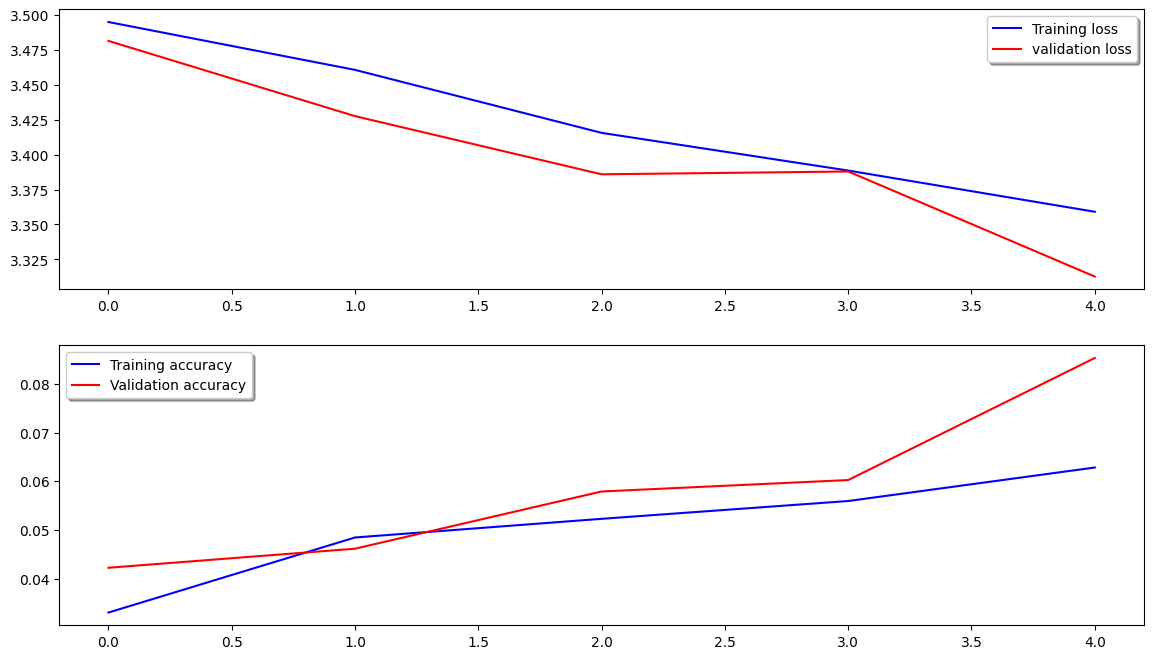

In [72]:
# Plot the loss and accuracy curves for training and validation
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [73]:
_, test_acc = saved_model.evaluate(X_test, y_test, verbose=0)
print('Test: %.3f' % (test_acc))

Test: 0.090


45/45 [==============================] - 3s 67ms/step


<Axes: >

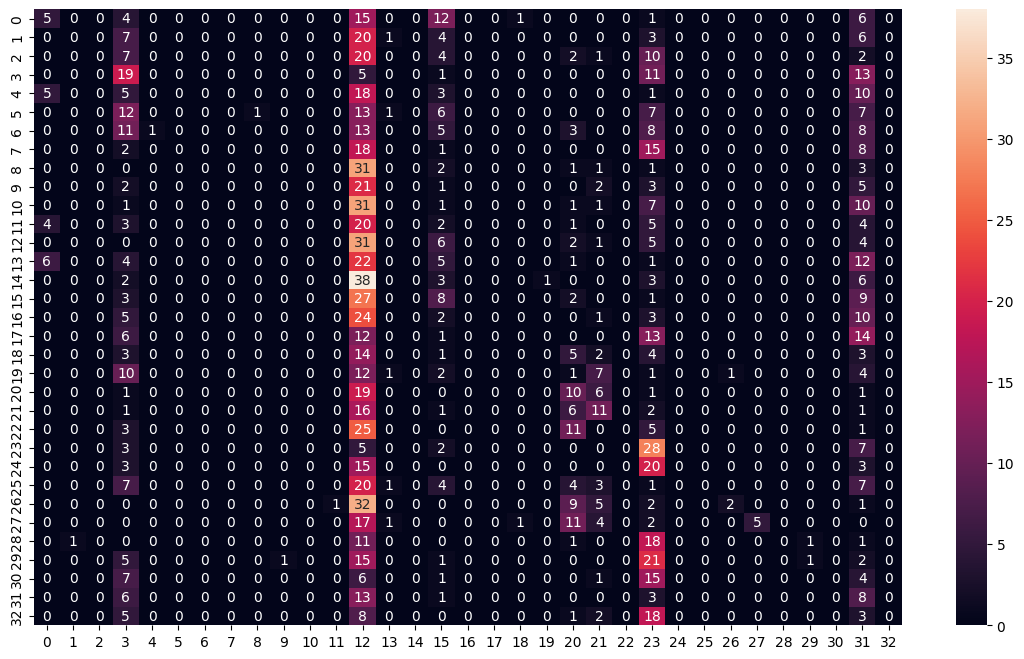

In [74]:
y_pred = deep_RU_model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test, axis=1)
confusion_mtx = confusion_matrix(y_test, y_pred)
sns.heatmap(confusion_mtx, annot=True, fmt='d')

45/45 [==============================] - 6s 122ms/step


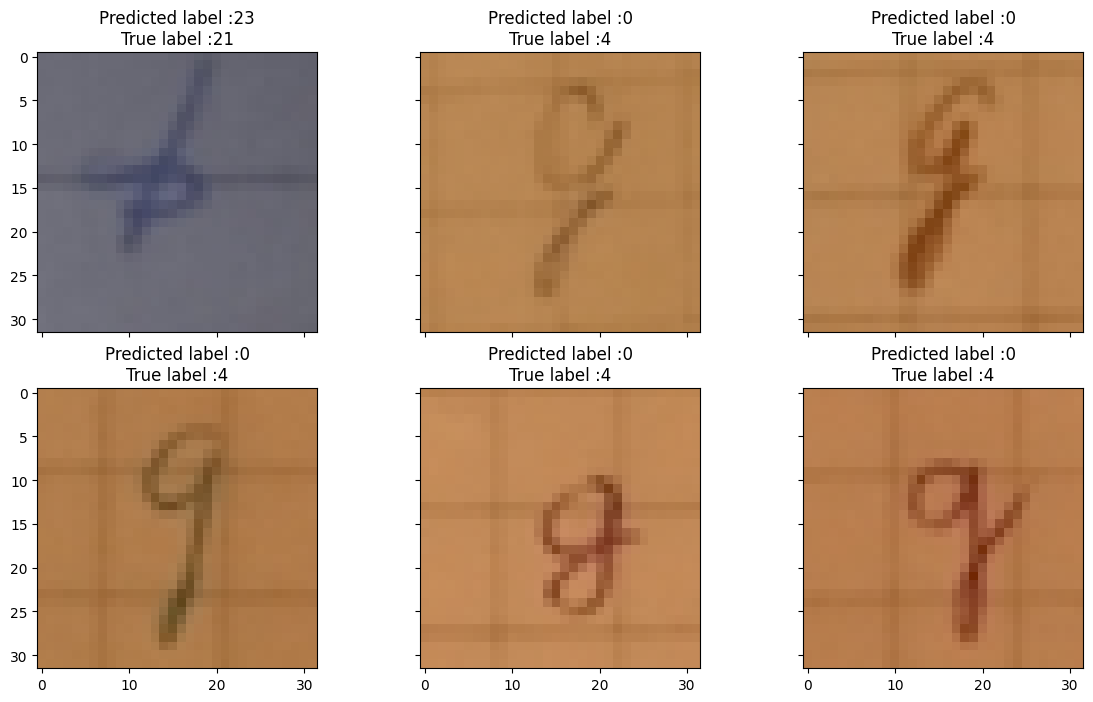

In [75]:
# Display some error results

# Convert one-hot vector to labels
Y_true = y_test

# Predict the values from the test dataset
Y_pred = saved_model.predict(X_test)
# Convert predictions from one-hot vectors to labels
Y_pred_classes = np.argmax(Y_pred,axis = 1)

# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_test[errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

# Probabilities of the wrongly predicted letters
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_delta_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors
most_important_errors = sorted_delta_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)